# Admixture

Genetic admixture occurs when two or more previously isolated populations begin interbreeding.<br>
Ancestry is admixed when an individual has some genetic ancestry from multiple populations.

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

In *msprime*, admixture events are specified in the same way as population splits: some fraction of the lineages move to a different deme.

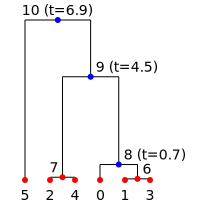

In [2]:
ts  = msprime.simulate(
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=6),
        msprime.PopulationConfiguration(sample_size=0)],
    demographic_events=[
        msprime.MassMigration(0.5, source=0, dest=1, proportion=0.5),
        msprime.MigrationRateChange(1.1, rate=0.1),
    ],
    random_seed=26)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.1f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels))

We begin in this example with 6 lineages sampled in population 0, zero samples in population 1, and with no migration between these populations. Then, at time 0.5, we have an admixture event where each of the 4 extant lineages (5, 7, 0 and 6) has a probability of 1/2 of moving to deme 1. Linages 0 and 6 migrate, and subsequently coalesce into node 8. Further back in time, at $t=1.1$, another demographic event occurs, changing the migration rate between the demes to 0.1, thereby allowing lineages to move between them. Eventually, all lineages end up in deme 1, where they coalesce into the MRCA at time $t=6.9$.

In [3]:
population_configurations=[
    msprime.PopulationConfiguration(sample_size=6),
    msprime.PopulationConfiguration(sample_size=0)]
demographic_events=[
    msprime.MassMigration(0.5, source=0, dest=1, proportion=0.5),
    msprime.MigrationRateChange(1.1, rate=0.1),
]

dp = msprime.DemographyDebugger(           
    population_configurations=population_configurations,
    demographic_events=demographic_events)
dp.print_history()

Epoch: 0 -- 0.5 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |    1        1                 0 |     0        0    
1 |    1        1                 0 |     0        0    

Events @ generation 0.5
   - Mass migration: lineages move from 0 to 1 with probability 0.5
Epoch: 0.5 -- 1.1 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |    1        1                 0 |     0        0    
1 |    1        1                 0 |     0        0    

Events @ generation 1.1
   - Migration rate change to 0.1 everywhere
Epoch: 1.1 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |    1        1                 0 |     0       0.1   
1 |    1        1                 0 |    0.1       0    



Demographic events happened in this order:<br>
- poppulation 0 and 1 exchanged migrants at rate 0.1
- at t = 1.1, migration stopped
- at t = 0.5, 50% of lineages of population 0 moved to population 1

# Two populations admixed 500 generations ago

Samples:<br>
- t = 0, admixed population
- t = 300, admixed population
- t = 600, population 0
- t = 600, population 1

In [4]:
Ne = 15000
nbPops = 2
nbM = 10
nbA = 10
M = 1
m = M/(4*Ne)

population_configurations=[
        msprime.PopulationConfiguration(initial_size=Ne),
        msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
        msprime.MassMigration(500, source=0, dest=1, proportion=0.5),
        msprime.MigrationRateChange(500, rate=m)]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(0,300) for i in np.arange(2*nbA)]
samples += [msprime.Sample(0,600) for i in np.arange(2*nbA)] + [msprime.Sample(1,600) for i in np.arange(2*nbA)]

In [5]:
def run_sim(num_replicates, nbM, nbA, population_configurations, demographic_events, samples):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 100,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  samples = samples,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM + 3*nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [6]:
g = allel.model.GenotypeArray(run_sim(8000, nbM, nbA, population_configurations,
                                                         demographic_events, samples))
g

<GenotypeArray shape=(5451, 40, 2) dtype=int8>
1/0 0/1 0/0 0/1 0/1 ... 0/0 1/1 0/0 1/0 1/1
0/0 0/0 0/0 1/0 0/0 ... 0/0 0/0 0/0 0/1 0/0
0/0 1/0 0/0 0/0 0/1 ... 0/0 0/0 0/0 0/0 0/0
...
1/1 1/0 0/1 0/1 1/0 ... 0/1 0/0 0/0 0/0 0/1
0/0 0/0 1/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [7]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

pops_colors = {
    'admixed, 0': '#df9fbf',
    'admixed, 300': '#993366',
    'pop0, 600': '#cc0000',
    'pop1, 600': '#336699'
}

pops = ['admixed, 0', 'admixed, 300', 'pop0, 600', 'pop1, 600']

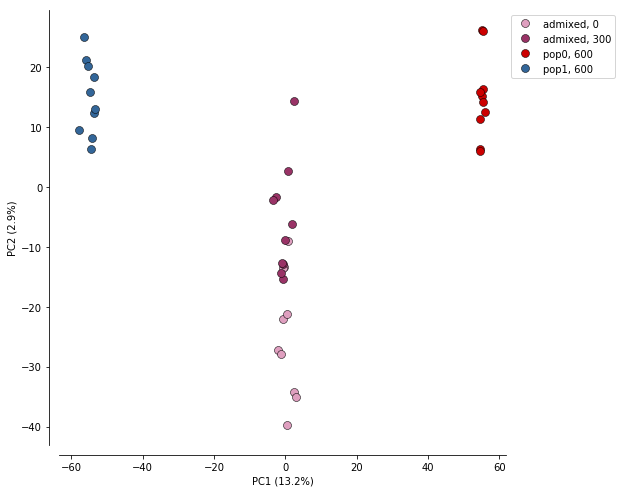

In [8]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops:
        x = coords[i:i+nbM, pc1]
        y = coords[i:i+nbM, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=8, mec='k', mew=.5)
        i += nbM
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(8,8))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

In [9]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    for pop in pops:
        y = coords[i:i+nbM, pc]
        x = np.arange(i, i+nbM)
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=6, mec='k', mew=.5)
        i += nbM
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')

    
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,2,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,2,2)
plot_PC_maps(coords, model, 1, ax)
"""
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax = fig.add_subplot(2,4,8)
plot_PC_maps(coords, model, 7, ax)"""
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

Text(0.5,1.02,'PC maps')

In [10]:
sample_pops = ['admixed, 0'] * nbM + ['admixed, 300'] * nbA + ['pop0, 600'] * nbA + ['pop1, 600'] * nbA
sample_times = [0] * nbM + [300] * nbA + [600] * 2*nbA

with open("genotype_admixture.txt", "w") as f:
    for ind in np.arange(gn.shape[1]):
        f.write("%s\t%s\t" % (sample_pops[ind], sample_times[ind]))
        for var in np.arange(gn.shape[0]):
            if var != gn.shape[0]-1:
                f.write("%s\t" % gn[var, ind])
            else:
                f.write("%s\n" % gn[var, ind])

PC1 = population<br>
PC2 = samples' age

## Compare admixture vs. one population for the same temporal sampling

In [11]:
Ne = 15000
nbSamples = 5
ages_before = [650, 700, 750, 800, 850, 900, 950]
ages_after = [0, 50, 100, 150, 200, 250, 300]
admixture_time = 600

m = 0.1/(4*Ne)

# one population
samples = []
ages = ages_after + ages_before
for a in ages:
    samples += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
    
def run_simu_one_pop(num_replicates, nbSamples, samples, ages, Ne):
    s = 0
    replicates = msprime.simulate(Ne=Ne, length= 2e2, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbSamples*len(ages),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

g_onePop = allel.model.GenotypeArray(run_simu_one_pop(5000, nbSamples, samples, ages, Ne))

# population split
population_configurations=[
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(admixture_time, source=0, dest=1, proportion=0.5),
    msprime.MigrationRateChange(admixture_time, rate=m)] 
samples_adm = []
for a in ages_after:
    samples_adm += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
for a in ages_before:
    samples_adm += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
for a in ages_before:
    samples_adm += [msprime.Sample(1,a) for i in np.arange(2*nbSamples)]

def run_simu_adm(num_replicates, nbSamples, samples_adm, population_configurations, demographic_events, ages_after, 
                 ages_before):
    s = 0
    replicates = msprime.simulate(length= 50,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events,
                                  samples = samples_adm)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (2*len(ages_before)*nbSamples + len(ages_after)*nbSamples,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

g_adm = allel.model.GenotypeArray(run_simu_adm(15000, nbSamples, samples_adm, population_configurations, demographic_events,
                                                  ages_after, ages_before))

In [12]:
g_onePop

<GenotypeArray shape=(3501, 70, 2) dtype=int8>
0/1 0/0 0/1 1/1 0/1 ... 1/0 1/1 0/0 1/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 1/1 1/1 1/1 0/1 ... 0/1 1/1 1/1 1/1 1/0
0/0 0/0 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [13]:
g_adm

<GenotypeArray shape=(10108, 105, 2) dtype=int8>
1/0 0/1 0/0 0/0 1/1 ... 0/0 1/0 0/0 1/0 0/0
1/0 0/0 1/0 0/1 0/0 ... 1/1 1/1 1/1 1/1 1/1
0/0 0/0 0/0 0/1 1/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 1/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/1

In [20]:
gn_adm = g_adm.to_n_alt()[:]
gn_onePop = g_onePop.to_n_alt()[:]

# ages_onePop = []
# for a in ages:
#     ages_onePop += [a for i in np.arange(nbSamples)]
# with open("genotype_onePop_adm.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn_onePop.shape[1]):
#         f.write("%s\t" % ages_onePop[i])
#         for var in np.arange(gn_onePop.shape[0]):
#             if var != gn_onePop.shape[0]-1:
#                 f.write("%s\t" % gn_onePop[var, ind])
#             else:
#                 f.write("%s\n" % gn_onePop[var, ind])
#         i += 1

ages_adm = []
for a in ages_after + ages_before + ages_before:
    ages_adm += [a for i in np.arange(nbSamples)]
with open("genotype_adm.txt", "w") as f:
    i = 0
    for ind in np.arange(gn_adm.shape[1]):
        f.write("%s\t" % ages_adm[i])
        for var in np.arange(gn_adm.shape[0]):
            if var != gn_adm.shape[0]-1:
                f.write("%s\t" % gn_adm[var, ind])
            else:
                f.write("%s\n" % gn_adm[var, ind])
        i += 1

coords_onePop, model_onePop = allel.stats.pca(gn_onePop, scaler=None)
coords_adm, model_adm = allel.stats.pca(gn_adm, scaler=None)

In [15]:
palette_onePop = sns.color_palette("YlOrRd", len(ages))
palette_adm = sns.color_palette("YlGnBu", len(ages) + len(ages_before))

colors_onePop = {}
onePop = []
i = 0
for a in ages:
    name = "one pop, t=" + str(a)
    onePop.append(name)
    colors_onePop[name] = palette_onePop[i]
    i += 1

colors_adm = {}
adm = []
i = 0
for a in ages_after:
    name = "admixed, t=" + str(a)
    adm.append(name)
    colors_adm[name] = palette_adm[i]
    i += 1
for a in ages_before:
    name = "pop0, t=" + str(a)
    adm.append(name)
    colors_adm[name] = palette_adm[i]
    i += 1
for a in ages_before:
    name = "pop1, t=" + str(a)
    adm.append(name)
    colors_adm[name] = palette_adm[i]
    i += 1

Text(0.5,1,'Population admixture')

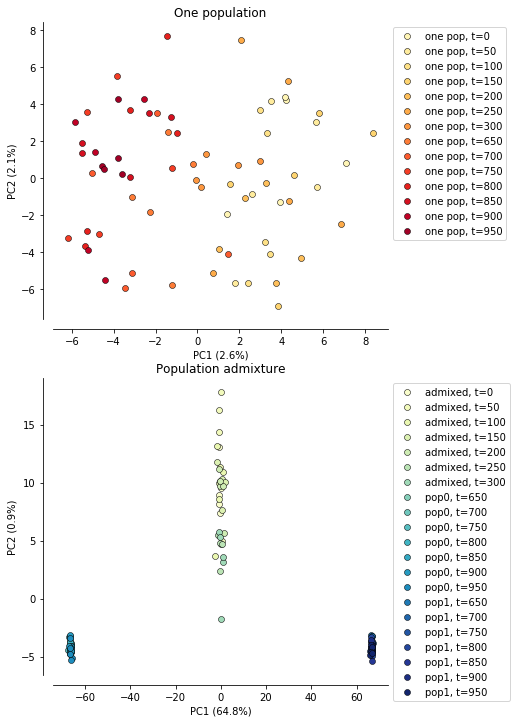

In [16]:
def plot_pca_coords(coords, model, pc1, pc2, ax, nbSamples, l, colors):
    sns.despine(ax=ax, offset=10)
    i = 0
    for a in l:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
                color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))    

    
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1)
plot_pca_coords(coords_onePop, model_onePop, 0, 1, ax, nbSamples, onePop, colors_onePop)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("One population")
ax = fig.add_subplot(2,1,2)
plot_pca_coords(coords_adm, model_adm, 0, 1, ax, nbSamples, adm, colors_adm)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Population admixture")

Text(0.5,1,'Population admixture')

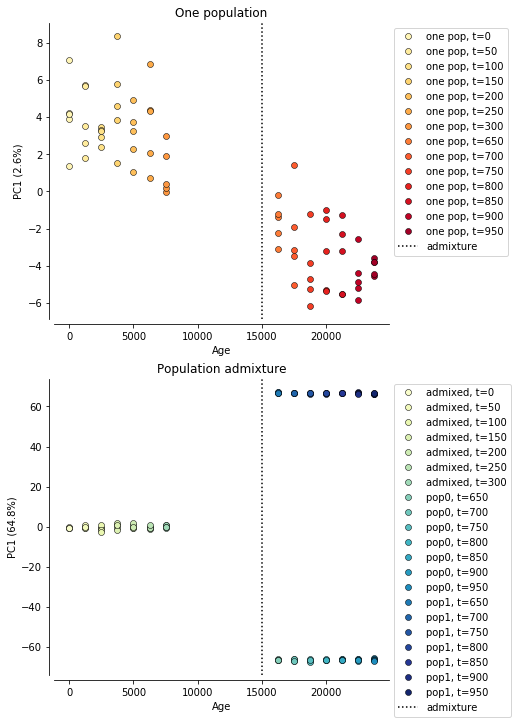

In [17]:
def plot_PC_maps(coords, model, pc, ax, nbSamples, l, colors):
    sns.despine(ax=ax, offset=5)
    i = 0
    for a in l:
        y = coords[i:i+nbSamples, pc]
        x = np.ones(len(y))
        words = a.split('=')
        ax.plot(x*int(words[1])*25, y, marker='o', linestyle=' ', label=a, color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age')
    ax.axvline(admixture_time*25, linestyle=':', color="black", label="admixture")
    
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1)
plot_PC_maps(coords_onePop, model_onePop, 0, ax, nbSamples, onePop, colors_onePop)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("One population")
ax = fig.add_subplot(2,1,2)
plot_PC_maps(coords_adm, model_adm, 0, ax, nbSamples, adm, colors_adm)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Population admixture")

## Fst between populations

Writing a CSV file and defining subpopulations is necessary to compute the Fst between populations.

In [18]:
import csv
import pandas

pops_names = ['admixed', '0', '1']

k = 0
with open('admixture.csv', 'w') as f:
    fieldnames = ['index', 'population']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for i in np.arange(len(pops_names)):
        for j in np.arange(nbSamples*len(ages_before)): # len(ages_after) == len(ages_before)
            writer.writerow({'index': str(k), 'population': pops_names[i]})
            k += 1
    
df_samples_adm = pandas.read_csv('admixture.csv', sep=',', index_col='index')

subpops_adm = {
    'admixed': df_samples_adm[df_samples_adm.population == 'admixed'].index.tolist(),
    '0': df_samples_adm[df_samples_adm.population == '0'].index.tolist(),
    '1': df_samples_adm[df_samples_adm.population == '1'].index.tolist()
}

In [19]:
acs_adm = g_adm.count_alleles_subpops(subpops_adm)

fst_matrix_adm = np.zeros((len(pops_names), len(pops_names)))

for i in np.arange(len(pops_names)):
    for j in np.arange(len(pops_names)):
        if i != j:
            pop1 = pops_names[i]
            pop2 = pops_names[j]
            acu = allel.AlleleCountsArray(acs_adm[pop1][:] + acs_adm[pop2][:])
            flt = acu.is_segregating()
            ac1 = allel.AlleleCountsArray(acs_adm[pop1].compress(flt, axis=0)[:, :2])
            ac2 = allel.AlleleCountsArray(acs_adm[pop2].compress(flt, axis=0)[:, :2])
            # compute FST
            num, den = allel.stats.hudson_fst(ac1, ac2)
            fst = np.sum(num) / np.sum(den)
            fst_matrix_adm[i, j] = fst
        else:
            fst_matrix_adm[i, j] = 0

mask = np.zeros_like(fst_matrix_adm)
mask[np.tril_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(fst_matrix_adm, xticklabels=pops_names, yticklabels=pops_names, annot=True, mask=mask, square=True,
                    linewidths=.5)
ax.set_title("Hudson's FST - Admixture (" + str(admixture_time) + " y. ago) scenario")
plt.show()